In [1]:
%run pylib/ml_fit show dark  kde title "Gevatar population estimate"
data = dfc.copy()
class_names = list(self.targets.keys())
unid = data[data.subset=='unid']
kde_features='d log_epeak diffuse'.split()
kde_bounds = dict(
              d=(0.2,2.0),
              log_epeak=np.log10([0.15, 4]),
                diffuse=(None, 2), )

# Gevatar population estimate

<h5 style="text-align:right; margin-right:15px"> 2024-02-29 12:50</h5>

Not applying ML, so no class fits to generate prediction model. Instead we compute KDE probability density distributions
for the ML targets, which we then apply to the unid and bcu associations.

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f82c7886a10>

### Data selection cut: "0.15<Ep<4 & d>0.2 & variability<25"

subset,blazar,psr,msp,unid
total,2283,140,176,2349
selected,162,128,169,1389
%,7,91,96,59


## Create KDE functions instead of ML training
* Classes: psr, msp, blazar
* Features: d, log_epeak, diffuse 

In [3]:
class Features(dict):
    """ class Featues:
        Manage binning properties in the features space
    """
    def __init__(self, names, limits, N=25):
        self['names'] = names
        self['limits'] = dict((name, np.array(lim).round(3)) for name,lim in zip(names, limits))
        self['bins'] = bins =dict( (var, np.linspace(*self['limits'][var],num=N+1 ).round(3)) for var in names)
        cvals = lambda b: (b[1:]+b[:-1])/2
        self['centers'] = dict((nm, cvals(v).round(3)) for nm,v in bins.items()) 
        delta = lambda name: self['limits'][name][1]-self['limits'][name][0]
        self['size'] = dict((name, delta(name)) for name in kde_features)
        self['N']=N
        self['volume']=  np.prod([lim[1]-lim[0] for lim in limits])
        self.__dict__.update(self)

    def __repr__(self):
        return 'class Features:\n'+'\n'.join( [f'{key}: {value}' for key, value in self.items()])
        
    def meshgrid(self):
        """ Return a 3-D meshgrid as a DataFrame
        """
        return pd.DataFrame(dict( (name, mg.flatten()) for name,mg in
                       zip(self.names, np.meshgrid(*self.centers.values()))))
show(Features.__doc__)           

class Featues:
Manage binning properties in the features space

In [4]:
show(f"""## Evaluate KDE's for components & unid with bounded={(bounded:=True)}""")
from pylib.kde import ComponentProb
kdes = {}
for name, df in zip(class_names+['unid'],
                    [data[data.subset==s] for s in  class_names] + [unid],
                   ):
    old= data[name+'_kde']
    if bounded:
        kdes[name]= gk = ComponentProb(df, kde_features, kde_bounds)
        new= gk(data)
        data[name+'_kde'] = new
    else:
        kdes[name]= gk = ComponentProb(df, kde_features,)
        new= gk(data)
        print(name, np.all(old==new))



## Evaluate KDE's for components & unid with bounded=True

In [41]:
show(f"""### Evalute {'Bounded' if bounded else ''} KDE on a grid, N={(N:=25)}""")
# make dicts with limits, bins, bin centers
     
ft = Features(kde_features, [[0.2,2], np.log10([0.15,4]).round(3), [-0.4,2]], N=N)
grid = ft.meshgrid()
         

show("""* Evaluate KDE on the grid, measure integrals, renormalize""")
for comp in class_names+['unid']:
    grid[comp+'_kde'] = kdes[comp](grid)
# check integrals
norms = grid.iloc[:,-4:].sum() * ft.volume/ft.N**3
with pd.option_context('display.precision',4):
    show(pd.Series(norms, name='integral'))
grid.iloc[:, -3:] /= norms

### Evalute Bounded KDE on a grid, N=25

* Evaluate KDE on the grid, measure integrals, renormalize

,psr_kde,msp_kde,blazar_kde,unid_kde
integral,1.6117,1.4697,0.99,1.4718


In [48]:
(grid * ft.volume/ft.N**3).sum(), grid.head()

(d             5.994828
 log_epeak    -0.604979
 diffuse       4.360206
 psr_kde       1.611694
 msp_kde       1.000000
 blazar_kde    1.000000
 unid_kde      1.000000
 dtype: float64,
        d  log_epeak  diffuse   psr_kde   msp_kde  blazar_kde  unid_kde
 0  0.238     -0.794    -0.35  0.018143  0.000067    0.510495  0.038608
 1  0.238     -0.794    -0.25  0.019979  0.000156    0.487170  0.048142
 2  0.238     -0.794    -0.15  0.019138  0.000302    0.458072  0.056871
 3  0.238     -0.794    -0.05  0.016595  0.000486    0.435652  0.065071
 4  0.238     -0.794     0.05  0.014620  0.000652    0.412323  0.074913)

In [59]:
grid.describe(), N**3

(                  d     log_epeak       diffuse       psr_kde       msp_kde  \
 count  13824.000000  13824.000000  13824.000000  1.382400e+04  1.382400e+04   
 mean       1.099917     -0.111000      0.800000  2.957097e-01  1.834776e-01   
 std        0.519195      0.411271      0.692244  4.327618e-01  2.963288e-01   
 min        0.238000     -0.794000     -0.350000  1.530346e-08  1.415860e-09   
 25%        0.669000     -0.452750      0.225000  3.435551e-02  2.197716e-03   
 50%        1.100000     -0.111000      0.800000  1.209548e-01  5.407373e-02   
 75%        1.531750      0.230750      1.375000  3.605364e-01  2.243412e-01   
 max        1.962000      0.572000      1.950000  2.765917e+00  1.858721e+00   
 
          blazar_kde      unid_kde  
 count  1.382400e+04  13824.000000  
 mean   1.834776e-01      0.183478  
 std    3.438277e-01      0.150937  
 min    6.593233e-16      0.000017  
 25%    1.343728e-04      0.066721  
 50%    2.712093e-02      0.146600  
 75%    1.965434e-0

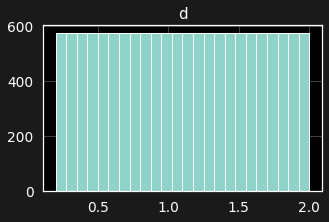

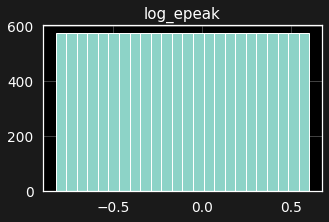

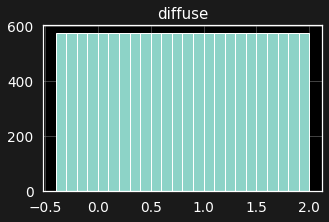

In [57]:
for var in kde_features:
    grid.hist(var, bins=ft.bins[var])

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f82bd23bd30>
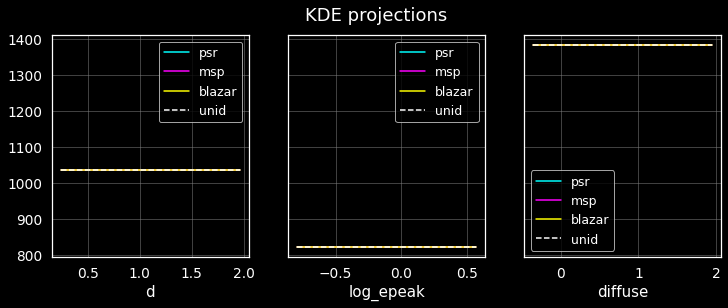

In [51]:
fig = plt.figure(figsize=(12,4))
axx = fig.subplots(ncols=3, sharey=True )
fig.suptitle('KDE projections')

# loop ove featues
for var_name,ax in zip(kde_features,axx.flat): 
    var_bins=ft.bins[var_name]

    # loop over classes
    for cls, color in zip(class_names+['unid'], self.palette+['w']):
        kde_name = cls+'_kde'
        h, _ = np.histogram(grid[var_name],  bins=var_bins, 
                           #weights=grid[kde_name]#*ft.size[var_name]/N**2,
                           )
        # h *= ft.size[var_name]/ft.N**3 /norms[kde_name
        # h *= (ft.volume/ft.N**2)/ ft.size[var_name]
        
        # print(var_name,cls, ft.size[var_name],  (np.sum(h)).round(4))
        ax.plot(ft.centers[var_name], h*ft.size[var_name], label=cls, color=color,
                ls='--' if cls=='unid' else '-');
    ax.set(xlabel=var_name)#, ylim=(0,None))    
    ax.legend(fontsize='small');
# axx[0].set(yticks=np.arange(0, 50, 10));
show(fig)

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f82bf736140>
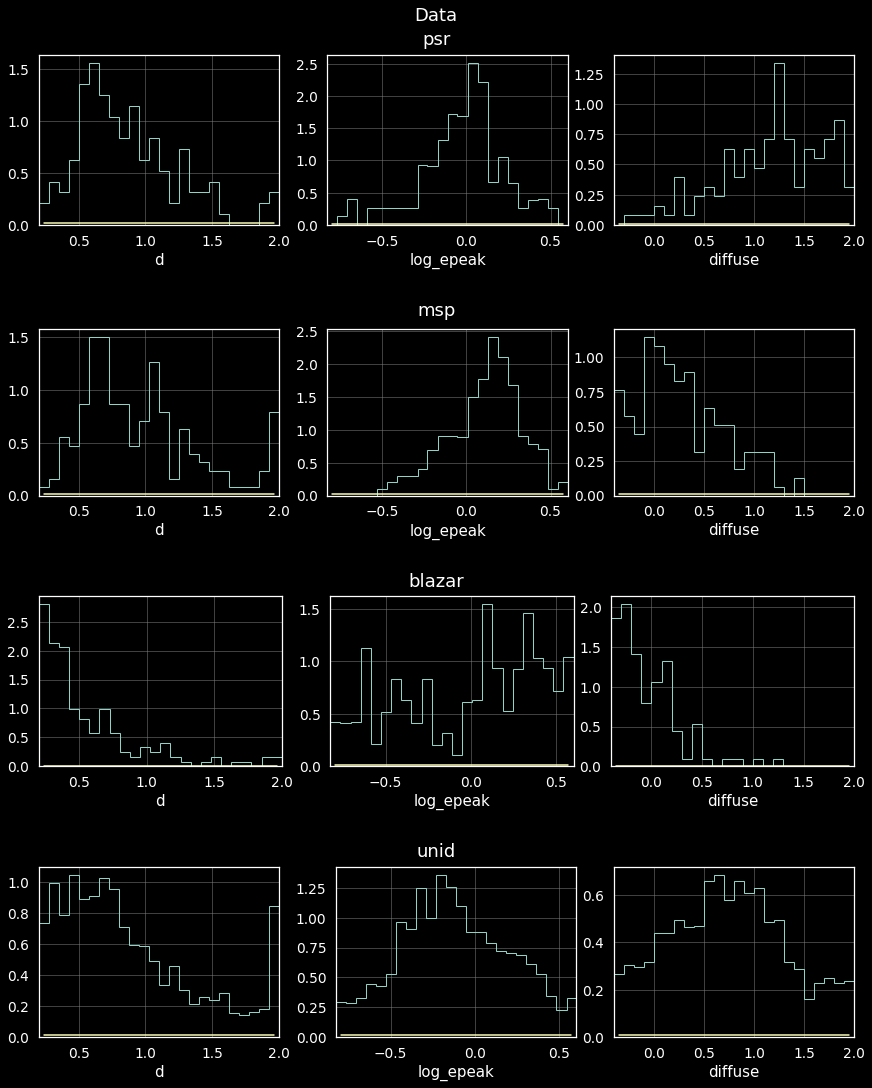

In [27]:
hkw=dict(histtype='step', density=True)

def subset_hists(cls, fig):
    fig.suptitle(cls)
    hkw = dict(histtype='step', density=True)
    axx = fig.subplots(ncols=3)
    df = data[data.subset==cls] if cls !='unid' else unid
    for ax, var_name in zip(axx, kde_features):
        ax.hist(df[var_name], bins=ft.bins[var_name], **hkw)
        ax.set(xlabel=var_name, xlim=ft.limits[var_name], )#yticks=[])
        h, _ = np.histogram(grid[var_name], bins=ft.bins[var_name], #weights=grid[cls+'_kde']
                           ); 
        ax.plot(ft.centers[var_name], h/norms[kde_name]/ft.size[var_name]/N**3) #label=cls, color=color,


        
fig = plt.figure(layout="constrained",figsize=(12,15))
fig.suptitle('Data')

data_names = class_names+['unid']
subfigs = fig.subfigures(nrows=len(data_names), hspace=0.1)

for cls, subfig in zip(data_names, subfigs):
    subset_hists(cls, subfig)
show(fig)

In [ ]:

# sns.histplot(data, hue='subset',hue_order=class_names, bins=bins['d'], x='d',
#              element='step',stat='density', palette=self.palette);
sns.histplot(unid, bins=bins['d'], x='d', color='none', element='step',stat='density',edgecolor='w');

In [ ]:
# from pylib.kde import ComponentProb


# def multi_study(features, bounds):

#     def study(fig, var, bounds):
#         for df, ax in zip(
#                 [data[data.subset==s] for s in 'psr msp blazar'.split()] + [unid], 
#                  fig.subplots(nrows=4, sharex=True),
#                  ):
#             gk = ComponentProb(df, features, bounds)
#             p = gk(df)
#             sns.scatterplot(df, ax=ax, x=var, y=p,s=10)

#         return fig
        
#     fig = plt.figure(layout="constrained", figsize=(12, 8 ))
     
#     for subfig, var in zip(fig.subfigures(ncols=3), features):
#         study(subfig, var, bounds)
#     return fig

# show_fig(multi_study, kde_features, kde_bounds)        

In [ ]:
def kde_analysis(data, subs, names, thresh_dict):
    """KDE distributions. An array of plots where the horizontal axis for each column
    is the KDE distribution for one of the known components. The top row is a scatter plot with respect to
    the unid KDE, in which the points are colored for each of the component KDE values exceding a threshold.
    THe second row is the cumuative distribution of the unid KDE. The lower two rows reflect properties of the 
    component KDE: the histogram and its cumulative distribution.
    The vertical dashed lines reflect thesholds used to make estimates of the component's content.  
    """
    fig, axx = plt.subplots(ncols=len(names), nrows=4, figsize=(15,10), 
                            height_ratios=(4,2,2,2),
                            sharey='row', sharex='col')
    
    # loop over columns
    for col,name in enumerate(names):
        x = f'{name}_kde'
        thresh = thresh_dict[name]
        
        # first two rows: scatter with unid, cumulative 
        unid_data = subs['unid']['data']
        unid_kde = unid_data.unid_kde
        unid_kw = dict(ax=axx[0,col], x=x, y=unid_kde, edgecolor='none',)
        sns.scatterplot(unid_data, **unid_kw, c='0.5', s=10).set(title=name)
        for tname,color in zip(names, 'red orange limegreen'.split()):
            sns.scatterplot(unid_data[unid_data[tname+'_kde']>thresh_dict[tname]], **unid_kw, c=color, s=20)
        sns.ecdfplot(unid_data, ax=(axu:=axx[1,col]), x=x,).set(ylim=(0.8,1))  
       
        #second two rows: kde of name
        sub_kde=subs[name]['data'][name+'_kde']
        sns.histplot(ax=axx[2,col], x=sub_kde, element='step', bins=25)
        sns.ecdfplot(ax=(axs:=axx[3,col]), x=sub_kde)
    
        # plot position of thresholds, calcualte estimate
    
        unid_kde_sub = unid_data[x]
        nu = len(unid_kde_sub); ku = np.sum(unid_kde_sub>thresh)
        ns = len(sub_kde);  ks = np.sum(sub_kde>thresh)
        estimate = int(ns/ks * ku)
        axu.plot(thresh, (nu-ku)/nu, 'or', ms=10, label=f'{ku}/{nu}'); 
        axu.legend(loc='lower right', fontsize=12)
        axs.plot(thresh, (ns-ks)/ns, 'or', ms=10,label=f'{ks}/{ns}\n->{estimate} '); 
        axs.legend(loc='lower right', fontsize=12)
        subs[name]['estimate']=estimate   
        subs[name]['factor'] = estimate/ns
        for ax in axx[:,col]:
            ax.axvline(thresh, ls='--', color='pink')
    fig.text(0.06, 0.6, 'unid kde', rotation='vertical', va='center', ha='center' )
    fig.text(0.06, 0.3, 'component kde', rotation='vertical', va='center', ha='center' )
        
    return fig

In [ ]:
show(f"""## Large KDE analysis
Idea: Estimate fractional component of the known types based on number of 
high-kde values, and individual distsribution.""")


subs = dict( (name, dict(data=sdf)) for name,sdf in data.groupby('subset'))
show_fig(kde_analysis, data, subs, class_names,
         thresh_dict=dict(psr=1.5, msp= 1.5,blazar= 1) )

In [ ]:
show("""## Define a partial likelihood and maximize it
That is, form the likelihood using the probabilities for each known component class defined by 
the KDE analysis and optimize unknown factors for each one.
This is partial since the gevatar probability distribution is unknown.""")

class UnidLikelihood:
    def __init__(self, data, names):
        self.data = data
        self.names = names
        sub_df = dict((name, df) for name,df in data.groupby('subset'))        
        self.g = g = sub_df['unid'].loc[:,[name+'_kde' for name in names]]
        self.norms = data.groupby('subset').size()[names].values
    
    def __call__(self, counts):
        alpha = counts/self.norms
        t = (self.g*alpha).sum(axis=1)
        return  (np.log(t) -t).sum()

    def fit(self, x0=np.array([250,200,300])) :
        from scipy  import optimize
        opt = optimize.minimize(lambda x: -self(x), 
             x0=x0, method='L-BFGS-B')
        B = opt.hess_inv  # LinearOperator object
        cov = B * np.identity(B.shape[1]) 
        diag = cov.diagonal()

        nfit = pd.Series(opt.x, index=self.names,name='counts')
        sigs = pd.Series(np.sqrt(diag), index=self.names, name='+/-')
        return pd.DataFrame([nfit, sigs])
        

UL = UnidLikelihood(data, names[:3])
show('Results:')
with pd.option_context('display.precision', 0):
    show((ulfit:=UL.fit()))
show(f'Estimate for the gevatar content: {len(unid)-int(ulfit.sum(axis=1)[0])}.')


In [ ]:
kdes['unid']

In [ ]:
def diffuse_contributions(data, kdes, model, *, ax=None, var, bins,xlim, legend_pos=None, dcut=1.95):
    
    """ Histogram of the diffuse parameter D for unid's.
    Also shown overlayed plots of the KDE approximations
    to known categories, with estimated normalizations.
    """
    from pylib.kde import Gaussian_kde
    # kdes = [Gaussian_kde(  data.query(f'subset=="{subset}"'), cols=[var]) for subset in model['names']] 
    unid = data[data.subset=="unid"]
    # scaling from density to coiunts
    N, binsize = len(unid), bins[1]-bins[0]
    factor = binsize# *N
    
    fig, ax = plt.subplots(figsize=(8,6)) if ax is None else (ax.figure, ax)
    hkw = dict(element='step', x=var, bins=bins)
    sns.histplot(unid, ax=ax,  # hue='in_corner', alpha=0.6, palette='grey red'.split(),
              edgecolor='w'if dark_mode else 'k', color='0.5' if dark_mode else '0.8', **hkw) 
    # sns.histplot(unid[unid.d>dcut], color='1', **hkw)
    
    if var != 'log_epeak':
        ax.set(xlabel=var )#xlim=(-1,2.5), xticks=np.arange(-1, 2.1, 1)
    else: ax.set(**epeak_kw())
    
    axt = ax.twinx()
    colors = palette = self.palette #['cyan', 'magenta', 'yellow']
    
    x=np.linspace(bins[0], bins[-1], 52)
    
    yy = np.array(
        [factor*norm* kde.evaluate(x) for (kde,norm) in zip(kdes, model['norms'])]
    )
                      
    
    for y, name, count, color in zip(yy, model['names'], model['norms'],
                                    'red orange limegreen'.split(), ):
        axt.plot(x,y, label=f'{name} ({count})', ls='-', lw=2, color=color)
    axt.plot(x, np.sum(yy,axis=0), ls='-', color='w', lw=4, label='total')
    if legend_pos is not None:
        axt.legend(fontsize=12, bbox_to_anchor=legend_pos, loc='upper left',)

    axt.set(ylim=ax.get_ylim(), xlim=xlim)
    axt.get_yaxis().set_visible(False)
    return fig

In [ ]:
show(f"""## Projections showing predicted target distributions""")
def projection(subs, norms,  names, features):
    model = dict(names = names,
                 norms=np.array(norms), # [subs[name]['estimate'] for name in names], #[201,181,109],
                )
    var_dict = dict( (name, bins) for name,bins in zip(features,
                    [np.arange(0.2, 2.01,0.05), np.arange(*np.log10([0.2,4]),0.1),  
                     np.arange(-1,2.6, 0.1), ],  
                   ))
    fig, axx = plt.subplots(ncols=3, figsize=(15,4), gridspec_kw=dict(wspace=0.25))
    for  (var, bins), xlim, ax, lpos in zip (var_dict.items(), 
                                           [(0,2.1), (-1,1), (-1,2.2)],
                                           axx, 
                                           [None,None, (1.04,1)]
                                         ):
        diffuse_contributions( data, model, ax=ax, var=var, bins=bins, xlim=xlim, legend_pos=lpos)
    return fig
features='d log_epeak diffuse'.split()
show_fig(projection, subs, [246,208,250], class_names, features=features)

In [ ]:
unid = data[data.subset=="unid"]
show(f"""### Check high $d$ and $D$""")
# $E_p$ vs $D$ for $d>{(dcutvalue:=1.9)}$: {sum((dcut:= unid.d>1.95))} sources.""")

fig = plt.figure(layout="constrained", figsize=(10, 5 ))
fig1, fig2 = fig.subfigures(ncols=2) 
ax = fig1.subplots()
fig1.suptitle(f"""High curvature\n $D$ vs $E_p$: {sum((dcut:= unid.d>1.95))} sources with $d>{(dcutvalue:=1.9)}$""")
sns.scatterplot(unid[dcut], ax=ax, x='log_epeak', y='diffuse')
ax.set(**epeak_kw(), ylabel='D', yticks=np.arange(0,2.1,1));

ax = fig2.subplots()
Dcut= unid.diffuse>1.5
fig2.suptitle(f"""Very galactic\n$d$ vs $E_p$: {sum(Dcut)} sources with $D>1.5$""")
sns.scatterplot(unid[Dcut] ,ax=ax,  x='log_epeak', y='d')
ax.set(**epeak_kw(), yticks=np.arange(0,2.1,0.5))
show(fig)



In [ ]:
show(f"""### Weighted distributions?
(Not now)""")
# For each unid source, """)
# # from pylib.kde import Gaussian_kde
# # kdes = dict((subset, Gaussian_kde(  data.query(f'subset=="{subset}"'), 
# #                      cols=(kde_vars := 'd log_epeak diffuse'.split()))) for subset in names )

# norms =np.array([246,208,250]) / [len(data[data.subset==name]) for name in names]
# K = unid.loc[:, [name+'_kde' for name in names] ]
# t = (K * norms).sum(axis=1)
# ax =  sns.histplot(t, element='step', bins=25)
# ax.set(xlabel='Sum of KDE probabilities')
# show(ax.figure)


In [ ]:
def plot_spectral(self, df, emax=1.5):
    """Spectral shape scatter plots: curvature $d$ vs $E_p$ for the associated sources on the left, and 
    the unid's on the right.
    """

    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,6), sharex=True, sharey=True,
                                gridspec_kw=dict(wspace=0.08))
    kw = dict(x='log_epeak', y='d',  hue='subset', edgecolor='k',)
    sns.scatterplot(df[np.isin(df.subset, self.target_names)], 
                    ax=ax1,  s=50, **kw,
                    palette=self.palette,    markers='oDv', 
                    legend='brief');
    ax1.set(**epeak_kw(), yticks=np.arange(0.5,2.1,0.5), ylabel='Curvature ${d}$',
        xlim=(-1,1),ylim=(0.1,2.1));
    ax1.legend(loc='upper right')
    
    sns.scatterplot(df[df.subset=='unid'], ax=ax2, **kw, 
                     color='0.8' if dark_mode else '0.2', legend=False, s=30 )
    # sns.kdeplot(df, ax=ax2, **kw, hue_order=self.target_names, palette=self.palette, alpha=0.4,legend=False );
    ax2.set(**epeak_kw(),)# yticks=np.arange(0.5,2.1,0.5));
    return fig
show(f"""## Spectral shapes of the associated and unid sources. """)
show_fig( plot_spectral, self, data) #.query('0.2<diffuse<1.2'),)

In [ ]:
show(f"""## The threshold effect
""")

(sns.JointGrid(data, hue='subset', hue_order='psr msp'.split(), height=9,
                palette=self.palette[:2],  x='diffuse', y=data.log_fpeak.clip(-2,4.8),)
    .plot_joint(sns.scatterplot, edgecolor='none',legend='brief',
               markers='oD')
    .plot_marginals(sns.histplot, kde=True, element='step', bins=25)
    .apply(lambda g: sns.kdeplot(unid,  ax=g.ax_joint, x='diffuse', y='log_fpeak',alpha=0.5))
    .apply(lambda g: g.ax_joint.set(**fpeak_kw('y'),  **diffuse_kw()))
     .apply(lambda g:g.ax_joint.plot([-0.5, 2], [-1.75, 1.65], 
                                     ls='--', lw=2, color='0.7' if dark_mode else '0.3')) 
    .apply(lambda g: show(g.figure))
);



In [ ]:
psr= data[data.subset=='psr']; 
from pylib.kde import Gaussian_kde
fig = plt.figure(figsize=(6,4))
ax = fig.subplots()
sns.histplot(psr.diffuse, ax=ax, element='step', bins=25, kde=True);
psr_kde = Gaussian_kde(psr, ['diffuse'])
binsize=0.1
factor = len(psr)*binsize
def pfun(kde, x):
    return (kde.evaluate(x) + kde.evaluate(4-x))
ax.plot((x:=np.arange(-0.5,2.1,0.1)),  pfun(psr_kde,x)*factor, '--')

fpcut=30
psrx = psr[psr.Fp>fpcut]
psr_kdex = Gaussian_kde(psrx, ['diffuse'])
ax.plot((x:=np.arange(-0.5,2.1,0.1)),  pfun(psr_kdex,x)*factor,
         '--', label=f'$F_p>{fpcut}$')
ax.legend()
show(fig)

In [ ]:
show("""
Assumptions about source probability distributions:
* The spectral shape ($E_p, d$) is independent of flux or position
* Positions, as reflected in the value of $D$, are independent
of the the peak flux __except__ for the threshold.
* The threshold is a simple function of $D$ with same shape

The exception is important since it biases the projections, 
especially the $D$ one which I naively use.

""")

In [ ]:
show(f"""## ECDF and logN-logS""")
pflux = data[data.subset=='psr'].log_epeak; 
sns.ecdfplot(data, hue='subset', hue_order='psr msp'.split(), x='log_epeak');

In [ ]:
show("""---""");raise Exception('Stop here')

In [ ]:
fig = plt.figure(figsize=(10,4))
fig.suptitle('Diffuse vs. latitude')
sns.scatterplot(data,ax=fig.subplots(),
                x='diffuse',y=np.log10(np.abs(data.glat)).clip(-2,2), s=10
               ).set(ylabel=r'$\log_{10}(|b|)$');

In [ ]:
def multi_plot(fig, name, adj=0):#1.25):

    dft=data.query(f'association=="{name}"')
    
    fig.suptitle(f'{name} - {len(dft)}', fontsize=20)
    axx = fig.subplots(ncols=3, gridspec_kw=dict(wspace=0.15) )
    sns.histplot(dft, ax=axx[0], x='diffuse', 
                 element='step', bins=np.arange(-1,2.4,0.1), kde=True).set(xlim=(-1,2.5))
    sns.scatterplot(dft, ax=axx[1], x='diffuse', #y='log_fpeak',
                    # y='log_fpeak',#
                    y= (dft.log_fpeak-adj*dft.diffuse), s=10,
                   ).set(xlim=(-1,2.5),ylim=(-3,5), ylabel='adjusted $F_p$')
    sns.scatterplot(dft, ax=axx[2], x='log_epeak', y='d', s=10,
                   ).set(xticks=np.arange(-1,1.1,1), yticks=np.arange(0,2.2,0.5))

show(f"""## Check specific distributions""")
names = 'unid psr msp spp bcu fsrq bll'.split()
fig = plt.figure(layout="constrained", figsize=(12, 3.*len(names)) )

for subfig, name in zip( fig.subfigures(len(names), 1, hspace=0.05,), names ):
    multi_plot( subfig, name )

show(fig)

In [ ]:
show(f"""## Likelihood fit with known components""")

g = unid.loc[:,[name+'_kde' for name in names]]
show(f"""Head of the known component KDE's for the {(N:=len(g))} unids""")
with pd.option_context('display.precision',3):
    show((g.head(2)))
show("Sums:")
show(pd.Series(g.sum(axis=0).round(), name='sum'))


s = pd.Series( dict( (name, subs[name]['factor'])  for name in names   ))
show(f"""Estimated factors from large KDE analysis:""")
with pd.option_context('display.precision',2):
    show(pd.Series(s,name='factor'))

gs = g * np.array([2.0, 1.15, 1.8])
a = lambda  k: g.iloc[:,k] #* 
b = (1/gs.sum(axis=1) -1) #.sum(axis=1)
[sum(a(k)*b) for k in range(3)]



In [ ]:
gs = g * np.array([2.0, 1.15, 1.8])

def loglike(alpha):
    t = (gs*alpha).sum(axis=1)
    return  (np.log(t) -t).sum()
    
x= np.linspace(0.8,1.2, 30)
peak = loglike(np.array( [1, 1, 1]))
def w(u, k):
    t = np.ones(3)
    t[k] = u
    return t
for k, label, ls in zip(range(3), names, ['--', ':', 'dashdot']):
    plt.plot(x, [loglike(w(u,k))-peak for u in x], ls=ls, label=label)
                                          
plt.gca().set(ylim=(-4, 0.05))
plt.legend()
show(plt.gcf())

In [ ]:
sub_df = dict((name, df) for name,df in data.groupby('subset'))
sub_df.keys()

In [ ]:
from scipy  import optimize
g = unid.loc[:,[name+'_kde' for name in names]]
def loglike(alpha):
    t = (g*alpha).sum(axis=1)
    return  (np.log(t) -t).sum()
    
norms = data.groupby('subset').size()[names].values #np.array([128, 169, 162])
x0 = np.array([250,200,300])
opt = optimize.minimize(lambda x: -loglike(x/norms), 
         x0=x0, method='L-BFGS-B')
B = opt.hess_inv  # LinearOperator object
cov = B * np.identity(B.shape[1]) 
diag = cov.diagonal()
nfit = pd.Series(opt.x.round(1), index=names,name='counts')

sigs = pd.Series(np.sqrt(diag).round(1), index=names, name='+/-')
show(pd.DataFrame([nfit, sigs]))

corr = cov/np.outer(sigs,sigs)
with pd.option_context('display.precision', 2):
    show(pd.DataFrame(corr, index=names, columns=names))
# data.groupby('subset').size()[names]

In [ ]:
def dloglike(alpha):
    t = (gs*alpha).sum(axis=1)
    # t = (gs).sum(axis=1) * alpha
    return N - np.sum(t)

for k, label, ls in zip(range(3), names, ['--', ':', 'dashdot']):
    plt.plot(x, [dloglike(w(u,k)) for u in x], ls=ls, label=label)
plt.legend()
show(plt.gcf())
show( 
    np.sum(gs.sum(axis=1))/N 
    )

In [ ]:
import numdifftools as nd
hess = nd.Hessian(loglike)
cov = np.linalg.inv(-hess(alpha)); 
diag = cov.diagonal()
sigs = np.sqrt(diag)
corr = cov/np.outer(sigs,sigs)

with np.printoptions(precision=3):
    print(sigs,'\n', corr)


In [ ]:
# class KDEfitter:
#     """### class KDEfitter
#     """
#     def __init__(self, data, *, names, bins, hue='subset', colname='diffuse'):
        
#         from pylib.kde import Gaussian_kde
#         self.names = names
#         self.colname = colname
#         # make list of 1D KDEE
#         self.kdes = [
#             Gaussian_kde(data.query(f'{hue}=="{name}"'), cols=[colname] )
#                                    for name in names
#                                     ]
#         self.data = data
#         self.hist, self.bins = np.histogram(self.data[self.data.unid][self.colname], bins=bins,)
#         self.x = ( bins[1:]+bins[:-1] )/2
        
#     def __repr__(self):
#         return f'KDEfittter using kdes\n {self.kdes}'

#     def eval(self, norms):
#         """ Evaluate expected counts
#         """
#         h,bins, x = self.hist, self.bins, self.x
#         N = h.sum()
#         factor = N*(bins[1]-bins[0]) # assume uniform
#         yy = np.array(np.array(
#                 [norm*kde.evaluate(x) for (kde,norm) in zip(self.kdes,norms)]
#                 )) 
#         u  = np.sum(yy, axis=0)*factor

#         return pd.DataFrame.from_dict(dict(x=x,u=u, h=h))
        
#     def plot(self, ax, norms):
#         # make a twin for separate legend
#         axt = ax.twinx()        
#         x = np.linspace(*ax.get_xlim(), 52)
#         yy = np.array(np.array(
#             [norm*kde.evaluate(x) for (kde,norm) in zip(self.kdes,norms)]
#             ))                  
#         for y, name in zip(yy, self.names):
#             axt.plot(x,y, label=name, ls='--', lw=2)
#         axt.plot(x, np.sum(yy,axis=0), ls='-', lw=2, label='total')
#         # same scale--dendsity
#         axt.set(ylim=ax.get_ylim())

#         axt.legend(title='KDE overlay',loc='center right',fontsize=12)
#         axt.get_yaxis().set_visible(False)
# show(KDEfitter.__doc__)
# kdef = KDEfitter(data, names=names, bins=None, colname=features)

In [ ]:
show(f"""## Show $D$ dependence in unid $d$ vs. $E_p$ plot """)
fig, ax = plt.subplots(figsize=(10,8))
kw = dict(x='log_epeak', y='d',   edgecolor='k',)
# sns.scatterplot(unid, ax=ax, **kw, 
#                  # color='0.8' if dark_mode else '0.2', 
#                 c = unid.diffuse,
#                 legend=False, s=30, cmap='coolwarm' )
scat = plt.scatter(x=unid.log_epeak, y=unid.d,
                c = unid.diffuse.clip(-0.5,2),s=30, cmap='rainbow' )
               
ax.set(**epeak_kw(), yticks=np.arange(0,2.1,0.5),ylabel='$d$')
plt.colorbar(scat).set_label('$D$')
show(fig)

In [ ]:
show("""## Correlation between peak and diffuse fluxes""")
show(f""" Correlation factor: {(factor:=1.25)}""") 
(sns.JointGrid(data, x='diffuse', y=(data.log_fpeak-factor*data.diffuse).clip(-3,2), 
                 xlim=(-1,2.4), ratio=6, height=8)
   .plot_marginals( sns.histplot, element='step', kde=True)
   .plot_joint(sns.regplot, ci=95, scatter_kws=dict(s=10, alpha=0.5), 
               line_kws=dict(color='r',lw=2))
   .apply(lambda g: g.ax_joint.set(ylabel=r'Adjusted peak flux: $\log F_p - 1.25\ D$', 
            xlabel='Diffuse correlation $D$',  xticks=np.arange(-1,2.1,1)))
   .apply(lambda g: show(g.figure))
);
# show(plt.gcf())#joint_kws=dict(s=10));


In [ ]:
show(f"""## What about "spp" sources?
From the 4FGL paper:
>SPP stands for "SNR, Pulsar or PWN" and refers to sources of unknown nature but overlapping with known SNRs or 
PWNe and thus candidate members of these classes.
""")

In [ ]:
show(f"""---
# End """)
raise Exception('Stop here')

In [ ]:
from pylib.kde import Gaussian_kde
gdes = dict( (name, Gaussian_kde(sdf, 'diffuse log_epeak d'.split()) )
                for name, sdf in data.groupby('subset') 
           )
    

gdes

In [ ]:
    
def evaluate(self, norms):
    """ Evaluate expected counts
    """
    n, bins, x = self.hist, self.bins, self.x
    N = n.sum()
    factor = N*(bins[1]-bins[0]) # assume uniform
    yy = np.array(
            [norm*kde.evaluate(x) for (kde,norm) in zip(self.kdes,norms)]
            )
    u  = np.sum(yy, axis=0)*factor

    df = DataFrame.from_dict(dict(x=x, u=u, n=n), orient='index')
    mask =  x >1.4
    mask  = x<0
   
    return np.sum( (n * np.log(u)-u ) * mask)

plt.plot((x:=np.arange(0.2,0.5, 0.025)), 
          [evaluate(self, [0.03, 0.37, x]) for x in x], 'o--');
[(x, evaluate(self, [0.05, x, 0.5])) for x in np.arange(0.2,0.5, 0.02)]

self = KDEfitter(data, names='blazar psr msp'.split(), bins= np.arange(-1,2.6, 0.1 ))

# fig, ax = plt.subplots(figsize=(8,6))

# sns.histplot(data[data.subset=='unid'], ax=ax, x='diffuse', hue='in_corner', alpha=0.6, palette='grey red'.split(),
#          element='step',  edgecolor='w', bins=self.bins,multiple='stack',stat='density');
# ax.set(xlim=(-1,2.5), xticks=np.arange(-1, 2.1, 1),xlabel='$D$')
# self.plot(ax=ax, norms = [0.03, 0.36, 0.4])

# show(fig)
# show(f"""Procedure:
# * Fit the psr component to D>1.4
# * fit blazar and msp components with D<0 """)

In [ ]:
# # fig, ax = plt.subplots(figsize=(8,6))
# df = self.eval((norms:= [0.05, 0.35, 0.3]))
# # sns.scatterplot(df, ax=ax, x='x', y='u', markers=['+'])
# # sns.scatterplot(df, ax=ax, x='x', y='h')
# # show(fig)
# loglike = lambda s: s.h * np.log(s.u) - s.u
# (np.sum(df.apply(loglike, axis=1)),
# evaluate(self, norms),)
# 1.0 * False


In [ ]:
dr4 = Fermi4FGL('dr4')
dr4.loc[final.index]

In [ ]:
pd.set_option('display.precision',3)
show(final)
show(f'{len(final)} sources')


In [ ]:
raise Exception("Stop here")

In [ ]:
show(f"""## Look at the 3PC table 5""")
t5="""\
   J0300.4+3450
   J0924.1-5202
   J1054.0-5938
   J1147.7-6618
   J1155.6-6245
   J1302.9-6349
   J1306.8-4035
   J1331.7-0343
   J1431.5-6627
   J1440.2-5505
   J1456.4-5923
   J1534.7-5842
   J1545.2-4553
   J1550.8-5424
   J1604.5-4441
   J1616.6-5009
   J1631.7-4826
   J1731.7-1850
   J1740.6-3430
   J1743.0-3201
   J1743.9-3539
   J1801.6-1418
   J1807.1+2822
   J1811.5-1925
   J1812.2-0856
   J1838.4-0545
   J1850.3-0031
   J1852.6+0203
   J1851.8-0007
   J1855.2+0456
   J1857.9+0313
   J1900.8+0118
   J1904.7+0615
   J1906.2+0631
   J1906.2+0631
   J1908.7+0812
   J1911.3+1055
   J1915.3+1149
   J1916.3+1108
   J1929.0+1729
   J1929.0+1729
   J1930.5+1853
   J1950.6+2416
   J1957.3+2517
   J2015.3+0758
   J2052.3+4437
   J2052.3+4437
   J2055.8+1545
   J2325.9+6206""".split('\n')[1:]
names = np.array(['4FGL '+line.split()[0] for line in t5]); names
missing = ~np.isin(names, data.index); 
sum(missing), names[missing]

In [ ]:
dr4=Fermi4FGL()
dr4.loc[names[missing]]

In [ ]:
dfi['d'] = data.d
dfi['d_unc'] = data.d_unc

from pylib.catalogs import UWcat
uwcat = UWcat('uw1410'); uwcat.head()

# uwx.pars.apply(lambda p: eval(p.split()[2])).values
# len(uwx)

# dfi['uw_name uw_pos uw_r95 d d_unc '.split()].sort_index()

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.scatterplot(ax=ax, x=final.r95, y=dfi.uw_r95)
ax.set(xlim=(0,.2,),ylim=(0,0.2), xticks=np.arange(0,0.21,0.05),yticks=np.arange(0,0.21,0.05))
ax.plot((0,.2),(0,.2), '--'); 

In [ ]:
show("""---""")
kent="""\
4FGL J0009.2+1745
4FGL J0144.3+5959
4FGL J0202.4+2943
4FGL J0418.9+6636
4FGL J0609.0+2136
4FGL J0904.7-4908
4FGL J1155.6-6245
4FGL J1205.1-5951
4FGL J1415.9-1504
4FGL J1418.7-6110
4FGL J1619.8-6314
4FGL J1653.2-4349
4FGL J1709.4-2127
4FGL J1711.4-2526
4FGL J1730.1-3422
4FGL J1745.6-3145
4FGL J1902.5+0654
4FGL J1919.4+1313
4FGL J1924.8-1035""".split('\n')
show(f"""## Kent's "dummy" list of {len(kent)}""")
show(f"""In data, len {len(data)}: {sum(np.isin(kent,data))} are in.""")
# sns.scatterplot(data.loc[kent], x='Ep', y='d');

In [ ]:
table3="""\
4FGL J0159.0+3313 bll
4FGL J0409.2+2542 bll
4FGL J0800.9+0733 bll
4FGL J0838.5+4013 bll
4FGL J0914.5+6845 bll
4FGL J1557.2+3822 bll
4FGL J0037.2-2653 blz
4FGL J0137.3-3239 blz
4FGL J0406.2+0639 blz
4FGL J0723.1-3048 blz
4FGL J0737.4+6535 blz
4FGL J0755.9-0515 blz
4FGL J0906.1-1011 blz
4FGL J0934.5+7223 blz
4FGL J1047.2+6740 blz
4FGL J1049.8+2741 blz
4FGL J1111.4+0137 blz
4FGL J1114.6+1225 blz
4FGL J1122.0-0231 blz
4FGL J1224.6+7011 blz
4FGL J1256.8+5329 blz
4FGL J1623.7-2315 blz
4FGL J1648.7+4834 blz
4FGL J1818.5+2533 blz
4FGL J1856.1-1222 blz
4FGL J2326.9-4130 blz
4FGL J0204.7+6656  psr
4FGL J0533.6+5945  psr
4FGL J0752.0-2931  psr
4FGL J0752.0-2931  psr
4FGL J0754.9-3953  psr
4FGL J1203.5-1748  psr
4FGL J1203.5-1748  psr
4FGL J1356.6+0234  psr
4FGL J1407.7-3017  psr
4FGL J1407.7-3017  psr
4FGL J1530.0-1522  psr
4FGL J1711.0-3002  psr
4FGL J1735.3-0717  psr
4FGL J1739.3-2531  psr
4FGL J1747.0-3505  psr
4FGL J1805.7+3401  psr
4FGL J1813.5+2819  psr
4FGL J1908.7+0812  psr
4FGL J1940.2-2511  psr
4FGL J2026.3+1431  psr
4FGL J2108.0+5155  psr
4FGL J2108.0+5155  psr
4FGL J2114.3+5023  psr
4FGL J2117.0+1344  psr
4FGL J2117.0+1344  psr
4FGL J2250.5+3305  psr""".split('\n') #;to_check
t3 = {}
for line in table3:
    t = line.split()
    name = t[0]+' '+t[1]
    t3[name] = t[-1]
t3s = pd.Series(t3, name='msc_id'); len(t3)

In [ ]:
t = np.isin(t3s.index, self.df.index, ); len(t), sum(~t), t3s.index[~t] #len(to_check), np.array(to_check)[~t]

In [ ]:
indr3 = np.isin( self.df.index, t3s.index)
check=self.df[indr3]
final = pd.concat([check, t3s], axis=1)['glat glon significance variability Fp Ep d msc_id'.split()]
final.groupby('msc_id').size(), len(final)

In [ ]:
for name, df in final.groupby('msc_id'):
    show(f'{name} {len(df)}')
    sedplotgrid(df)


In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(final, hue='msc_id', x=np.log10(final.Ep), y='d', palette=self.palette, ax=ax);

In [ ]:
ok = np.isin( final.index,dfc.index,)

In [ ]:
final.loc[ok]

In [ ]:
dfu = dfc.loc[np.isin(dfc.index, final.index,)]['Ep Fp d diffuse glat blazar_kde msp_kde psr_kde'.split()].query('blazar_kde<0.1'); dfu

In [ ]:
sns.scatterplot(dfu, x='msp_kde', y='psr_kde');

In [ ]:
dfu.query('msp_kde<0.1')

In [ ]:
show("""---
# Table 1 of [CXO paper](https://arxiv.org/pdf/2307.13594.pdf)
""")
tbl="""20324 2018-05-11 9.92 3FGL J1306.3−6043 304.768 2.086 3.51
20325 2018-02-18 9.76 3FGL J1906.6+0720 41.193 −0.028 9.95
20326 2018-07-07 9.92 3FGL J1104.9−6036 290.233 −0.389 3.72
23586 2021-07-10 9.93 4FGL J1736.1−3422 354.31 -1.17 1.9
23587 2021-07-24 9.92 4FGL J1639.3−5146 334.25 -3.33 2.7
23588 2021-01-28 9.92 4FGL J1203.9−6242 297.52 -0.34 3.8
23589 2021-06-20 9.93 4FGL J0854.8−4504 265.61 -0.03 2.3
23590 2020-12-14 9.95 4FGL J2035.0+3632 76.6 -2.34 1.2
23591 2020-10-25 9.91 4FGL J2041.1+4736 86.1 3.45 2.5
23592 2020-11-29 9.92 4FGL J1317.5−6316 305.86 -0.56 1.7
23593 2021-03-28 9.92 4FGL J1329.9−6108 307.56 1.38 1.4
23594 2020-10-10 9.92 4FGL J0744.0−2525 241.35 -0.74 2.0
23595 2021-02-02 10.61 4FGL J1358.3−6026 311.1 1.36 3.1"""\
    .replace('−','-').replace('J1906.6+0720','J1906.4+0723').replace('3FGL J1104.9-6036','4FGL J1104.9-6037').split('\n')
names = np.array(['4FGL '+line.split()[4]  for line in tbl])
show(f'Sources {names}')
names
#}') for line in tbl:
#     toks = line.split()
#     print(toks[3:5])    
    

In [ ]:
in4fgl = dfc.loc[names].sort_index()
from pylib.fermi_sources import sedplotgrid
sedplotgrid(in4fgl)

In [ ]:
in4fgl.query('subset=="unid"')

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
from pylib.tools import epeak_kw
ax.set(**epeak_kw(), xlim=(-0.5,1))
sns.scatterplot(in4fgl, hue='association',x='log_epeak', y='d', s=100,
                edgecolor='white', palette=self.palette, ax=ax);

In [ ]:
ig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(in4fgl, x='psr_kde', y='msp_kde', s=100,hue='association',
               palette=self.palette,ax=ax);

In [ ]:
pd.set_option('display.precision',3)
dfxx =in4fgl['glon glat d Ep Fp diffuse association psr_kde msp_kde '.split()] 
show(dfxx)


In [ ]:
def diffuse_contributions(data,  model, *, ax=None, var, bins, legend_pos=None):
    
    """ Histogram of the diffuse parameter D for unid's.
    Also shown overlayed plots of the KDE approximations
    to known categories, with estimated normalizations.
    """
    from pylib.kde import Gaussian_kde
    kdes = [Gaussian_kde(  data.query(f'subset=="{subset}"'), cols=[var]) for subset in model['names']] 
    unid = data[data.subset=="unid"]
    # scaling from density to coiunts
    N, binsize = len(unid), bins[1]-bins[0]
    factor = binsize# *N
    
    fig, ax = plt.subplots(figsize=(8,6)) if ax is None else (ax.figure, ax)
    sns.histplot(unid, ax=ax, x=var, # hue='in_corner', alpha=0.6, palette='grey red'.split(),
             element='step',  edgecolor='w', bins=bins, color='0.5',                
                 multiple='stack')#,stat='density');
    ax.set(xlabel=var, )#xlim=(-1,2.5), xticks=np.arange(-1, 2.1, 1)
    
    axt = ax.twinx()
    colors = palette = self.palette #['cyan', 'magenta', 'yellow']
    
    x=np.linspace(bins[0], bins[-1], 52)
    yy = np.array(np.array([factor*norm*kde.evaluate(x) for (kde,norm) in zip(kdes,model['norms'])]))                  
    for y, name, count, color in zip(yy, model['names'], model['norms'],
                                    'red orange limegreen'.split(), ):
        axt.plot(x,y, label=f'{name} ({count})', ls='-', lw=2, color=color)
    axt.plot(x, np.sum(yy,axis=0), ls='-', color='w', lw=4, label='total')
    if legend_pos is not None:
        axt.legend(fontsize=12, bbox_to_anchor=legend_pos, loc='upper left',)

    axt.set(ylim=ax.get_ylim())
    axt.get_yaxis().set_visible(False)
    return fig